In [24]:
!pip install transformers

In [25]:
!pip install torch===1.7.1 torchvision===0.8.2 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [26]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Importing and preprocessing datasets

In [27]:
pos_df = pd.read_csv('positive.csv', delimiter=';', header=None)
neg_df = pd.read_csv('negative.csv', delimiter=';', header=None)

In [28]:
pos_df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1
5,408906761769598976,1386325943,JustinB94262583,ну любишь или нет? — Я не знаю кто ты бля:D ht...,1,0,0,0,40,6,16,0
6,408906762436481024,1386325943,twinkleAYO,"RT @SpoonLamer: Ох,900 :D ну это конечно же @t...",1,0,1,0,5169,58,43,2
7,408906764114206720,1386325944,pycalyruhog,RT @veregijytaqo: У тебя есть ухажёр? Нет - мо...,1,0,2,0,393,112,153,0
8,408906764608749568,1386325944,grishintv,Поприветствуем моего нового читателя @Alexey17...,1,0,0,0,5872,1387,1431,12
9,408906765841870848,1386325944,alina_612,Теперь у меня есть частичка Сиднея :) #Sydney ...,1,0,0,0,263,5,36,0


In [29]:
df = pd.concat([pos_df, neg_df], ignore_index=True).sample(frac=1).reset_index(drop=True)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
0,409488839615721472,1386464721,ZaycevSV,"Хоть я и пьяный, но мне похуй что будет когда ...",1,0,0,0,7717,41,35,1
1,419468633702547456,1388844090,0kisel0,"хочу посмотреть какой-нибудь фильм, а вот не з...",-1,0,0,0,7236,613,603,6
2,424055682867138560,1389937728,deonmonroeixywk,блииин почему мне не приходит приглашение на т...,-1,0,0,0,2,0,0,0
3,409947468202119168,1386574067,bystrov_sasha,"@pianistkawlw Доброго тебе денечка, ну все мен...",1,0,0,0,4721,7951,4081,62
4,411539471365332993,1386953630,Anonim_dk,"@mental_collapse полистай ленту, я тут сам с с...",-1,0,0,0,13270,2698,284,25
5,409433845025366016,1386451610,violinist_Ann,@katy_deniska Да? А хотела чудной получится:) ...,1,0,0,0,1704,48,55,2
6,409489559672848384,1386464893,ValentineAdiyak,RT @zhenya721: ПЛАКАТ ВОЛИ \n#Євромайдан #Евро...,1,0,20,0,3004,64,63,1
7,411209836559626240,1386875039,margof_a,RT @Polina_16_07: всё последняя серия просмотр...,-1,0,1,0,1058,44,30,0
8,410135139000537089,1386618811,_just_amazing_,@ChestersCat я не намекал на тебя :D мне недав...,1,0,0,0,1859,182,142,2
9,422957287763116032,1389675850,DashaMalikovna,Так херово когда в школе разряжается телеф:(((,-1,0,0,0,885,544,594,1


In [30]:
df = df[df.columns[3:5]]
df.columns = [0,1]
df.head(10)

,0,1
0,"Хоть я и пьяный, но мне похуй что будет когда ...",1
1,"хочу посмотреть какой-нибудь фильм, а вот не з...",-1
2,блииин почему мне не приходит приглашение на т...,-1
3,"@pianistkawlw Доброго тебе денечка, ну все мен...",1
4,"@mental_collapse полистай ленту, я тут сам с с...",-1
5,@katy_deniska Да? А хотела чудной получится:) ...,1
6,RT @zhenya721: ПЛАКАТ ВОЛИ \n#Євромайдан #Евро...,1
7,RT @Polina_16_07: всё последняя серия просмотр...,-1
8,@ChestersCat я не намекал на тебя :D мне недав...,1
9,Так херово когда в школе разряжается телеф:(((,-1


In [31]:
df.shape

(226834, 2)

In [32]:
import re

def preprocess1(text):
        """Minimal text preprocessing
        """
        text = re.sub("^\s+|([A-Za-z])+|(@[A-Za-z0-9\_\-]+)|\n|\r|\s+$", ' ', text)
        return text.strip()


def preprocess2(num):
    if num == -1:
        return 0
    else:
        return num

In [33]:
df[0] = df.apply(lambda x: preprocess1(x[0]), axis=1)
df[1] = df.apply(lambda y: preprocess2(y[1]), axis=1)

In [34]:
df.head(10)

,0,1
0,"Хоть я и пьяный, но мне похуй что будет когда ...",1
1,"хочу посмотреть какой-нибудь фильм, а вот не з...",0
2,блииин почему мне не приходит приглашение на т...,0
3,"Доброго тебе денечка, ну все меняют, ты тоже ))",1
4,"полистай ленту, я тут сам с собой разговаривю,...",0
5,Да? А хотела чудной получится:) благодарю),1
6,: ПЛАКАТ ВОЛИ #Євромайдан #Евромайдан # #Укр...,1
7,: всё последняя серия просмотренна( ждём 2 сез...,0
8,я не намекал на тебя : мне недавно кто-то пис...,1
9,Так херово когда в школе разряжается телеф:(((,0


In [35]:
df[1].value_counts()

1    114911
0    111923
Name: 1, dtype: int64

In [36]:
df = df[:2000]
df[1].value_counts()

0    1013
1     987
Name: 1, dtype: int64

In [37]:
df

,0,1
0,"Хоть я и пьяный, но мне похуй что будет когда ...",1
1,"хочу посмотреть какой-нибудь фильм, а вот не з...",0
2,блииин почему мне не приходит приглашение на т...,0
3,"Доброго тебе денечка, ну все меняют, ты тоже ))",1
4,"полистай ленту, я тут сам с собой разговаривю,...",0
...,...,...
1995,: будь оптимистичнее: а если вернуться в ре...,1
1996,Жаль...#ПечальБедаОбидаааа((,0
1997,что у психолога из битвы экстрасенсов с ухом? ...,1
1998,"Нижний Тагил, за две недельки сквозь метель и ...",0


# Loading model

In [38]:
model_name = "DeepPavlov/rubert-base-cased-conversational"

tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModel.from_pretrained(model_name)

# Preparing the Dataset

In [39]:
tokenized = df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [40]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [41]:
np.array(padded).shape

(2000, 85)

In [42]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 85)

## Train

In [43]:
input_ids = torch.tensor(padded).to(torch.int64)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [45]:
last_hidden_states

BaseModelOutputWithPoolingAndCrossAttentions([('last_hidden_state',
                                               tensor([[[-0.9619, -0.5944, -1.3825,  ..., -0.4565,  0.7429, -0.8798],
                                                        [-0.0252, -0.5442, -0.6860,  ...,  0.7248,  0.6427, -0.7226],
                                                        [ 0.2336, -0.4209,  0.0240,  ...,  1.1019, -0.0944, -0.5097],
                                                        ...,
                                                        [ 0.8168,  0.0303, -0.1852,  ...,  0.5600,  0.3229, -0.4293],
                                                        [ 0.8068, -0.1295, -0.1604,  ...,  0.4700,  0.6295, -0.6259],
                                                        [ 0.6892, -0.1400, -0.1225,  ...,  0.4719,  0.4329, -0.5205]],
                                               
                                                       [[ 0.5160,  0.6477, -1.6605,  ...,  0.6959,  0.2367, -0.197

In [46]:
features = last_hidden_states[0][:,0,:].numpy()  
len(features[0])

768

In [47]:
labels = df[1]

# Model #2: Train

In [48]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [49]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
lr_clf.score(test_features, test_labels)

0.948

In [51]:
pred = lr_clf.predict(test_features)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr_clf.score(test_features, test_labels)))

Accuracy of logistic regression classifier on test set: 0.95


In [52]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_labels, pred)
print(confusion_matrix)

[[256  15]
 [ 11 218]]


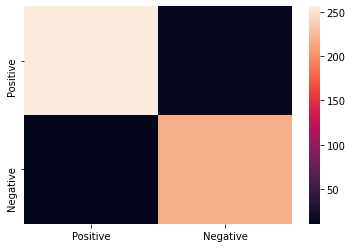

In [53]:
df = pd.DataFrame(confusion_matrix, index = ["Positive", "Negative"], columns = ["Positive", "Negative"])
sns.heatmap(df)

# Pipeline

In [121]:
# @torch.no_grad()
def predict(text):
    text = preprocess1(text)
    tokenized = tokenizer.encode(text, add_special_tokens=True)
    input = torch.tensor([tokenized]).to(torch.int64)

    
    last_hidden_states = model(input)

    features = last_hidden_states[0][:,0,:].numpy()

    pred = lr_clf.predict(features)
    if pred[0] == 1:
        print("Positive")
    else:
        print("Negative")

In [122]:
predict("У меня получилось обучить модель!")

Positive


In [123]:
predict("Она работает быстро")

Positive


In [124]:
predict("Жалко, что я сразу не нашел ошибку")

Negative


In [125]:
predict("Я люблю трансформеры")

Positive
